### <font color="green" style="calibre">Table of Contents</font>

[<font color="green" size=4.5>1. Importing Necessary Packages and Libraries</font>](#Importing-Necessary-Packages-and-lLbraries)


### <font color="green">1. Importing Necessary Packages and Libraries</font>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import bz2
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu, softmax
from keras.metrics  import Accuracy
from keras.losses import binary_crossentropy
from keras.callbacks import History
warnings.filterwarnings('ignore')

%matplotlib inline

### <font color="green">2. Loading Data</font>

<p>Since the data is compressed, I have to decompressed it duirng loading</p>

In [4]:
def load_data(file):
    data = bz2.BZ2File(file, "r")
    data = pickle.load(data)
    return data

In [5]:
PATH_TRAIN = '../data/raw/act_train.pbz2'
PATH_TEST = '../data/raw/act_test.pbz2'
PATH_PEOPLE = '../data/raw/people.pbz2'
train = load_data(PATH_TRAIN)
test = load_data(PATH_TEST)
people = load_data(PATH_PEOPLE)

### <font color="green">3. Exploring Data<font>

In [6]:
train.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [7]:
train.tail()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
2197286,ppl_99994,act2_4668076,2023-06-16,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 418,1
2197287,ppl_99994,act2_4743548,2023-03-30,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1832,1
2197288,ppl_99994,act2_536973,2023-01-19,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1
2197289,ppl_99994,act2_688656,2023-05-02,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 199,1
2197290,ppl_99994,act2_715089,2023-06-15,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1


In [8]:
train.columns

Index(['people_id', 'activity_id', 'date', 'activity_category', 'char_1',
       'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8',
       'char_9', 'char_10', 'outcome'],
      dtype='object')

In [9]:
row, col = train.shape
print('The length of the train row:', row)
print('The length of the train column:', col)

The length of the train row: 2197291
The length of the train column: 15


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197291 entries, 0 to 2197290
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   people_id          object
 1   activity_id        object
 2   date               object
 3   activity_category  object
 4   char_1             object
 5   char_2             object
 6   char_3             object
 7   char_4             object
 8   char_5             object
 9   char_6             object
 10  char_7             object
 11  char_8             object
 12  char_9             object
 13  char_10            object
 14  outcome            int64 
dtypes: int64(1), object(14)
memory usage: 251.5+ MB


In [11]:
train.isna().sum() / train.shape[0] # ratio/percentage of the null values for each attribute

people_id            0.000000
activity_id          0.000000
date                 0.000000
activity_category    0.000000
char_1               0.928268
char_2               0.928268
char_3               0.928268
char_4               0.928268
char_5               0.928268
char_6               0.928268
char_7               0.928268
char_8               0.928268
char_9               0.928268
char_10              0.071732
outcome              0.000000
dtype: float64

<p>We can see clearly below the bottom of the series above that the columns with names "char_#" has
about 93% of its values being null.<br> Let's remove them then.</p>

In [12]:
df = train.dropna(axis=1, ignore_index=True)
df.isna().sum() / df.shape[0]

people_id            0.0
activity_id          0.0
date                 0.0
activity_category    0.0
outcome              0.0
dtype: float64

In [13]:
df.describe(include=[object, int, float, bool])

,people_id,activity_id,date,activity_category,outcome
count,2197291,2197291,2197291,2197291,2.197291e+06
unique,151295,2197291,411,7,NaN
top,ppl_294918,act2_1734928,2022-09-30,type 2,NaN
freq,55103,1,48174,904683,NaN
mean,NaN,NaN,NaN,NaN,4.439544e-01
std,NaN,NaN,NaN,NaN,4.968491e-01
min,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,1.000000e+00


<p>Let's <strong>explore</strong> the people dataframe and see what we've got there too.</p>

In [14]:
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,type 2,type 4,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,True,True,False,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,type 2,type 2,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,type 2,type 2,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,type 2,type 2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,84


In [15]:
people.tail()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
189113,ppl_99987,type 1,group 8600,type 1,2022-04-02,type 4,type 6,type 4,type 3,type 11,type 2,type 2,False,True,False,True,False,True,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False,False,True,False,True,False,True,True,89
189114,ppl_9999,type 2,group 17304,type 2,2023-02-23,type 6,type 2,type 8,type 3,type 11,type 3,type 3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
189115,ppl_99992,type 2,group 17304,type 2,2020-06-25,type 5,type 5,type 3,type 4,type 16,type 3,type 3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
189116,ppl_99994,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95
189117,ppl_99997,type 2,group 17304,type 2,2022-03-12,type 40,type 25,type 9,type 3,type 8,type 6,type 6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,36


In [16]:
row, col = people.shape
print('The number of rows in train:', row)
print('The number of columns in train:', col)

The number of rows in train: 189118
The number of columns in train: 41


In [17]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189118 entries, 0 to 189117
Data columns (total 41 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   people_id  189118 non-null  object
 1   char_1     189118 non-null  object
 2   group_1    189118 non-null  object
 3   char_2     189118 non-null  object
 4   date       189118 non-null  object
 5   char_3     189118 non-null  object
 6   char_4     189118 non-null  object
 7   char_5     189118 non-null  object
 8   char_6     189118 non-null  object
 9   char_7     189118 non-null  object
 10  char_8     189118 non-null  object
 11  char_9     189118 non-null  object
 12  char_10    189118 non-null  bool  
 13  char_11    189118 non-null  bool  
 14  char_12    189118 non-null  bool  
 15  char_13    189118 non-null  bool  
 16  char_14    189118 non-null  bool  
 17  char_15    189118 non-null  bool  
 18  char_16    189118 non-null  bool  
 19  char_17    189118 non-null  bool  
 20  char

<p>Let's merge the people data with the train data based on the <strong>peeple_id</strong> as key</p?

In [18]:
merged_df = df.merge(people, on=["people_id"], how="inner")

In [19]:
merged_df.head()

,people_id,activity_id,date_x,activity_category,outcome,char_1,group_1,char_2,date_y,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,type 4,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,type 2,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,type 2,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,type 2,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,type 2,0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36


In [20]:
merged_df.tail()

,people_id,activity_id,date_x,activity_category,outcome,char_1,group_1,char_2,date_y,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
2197286,ppl_99994,act2_4668076,2023-06-16,type 4,1,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95
2197287,ppl_99994,act2_4743548,2023-03-30,type 4,1,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95
2197288,ppl_99994,act2_536973,2023-01-19,type 2,1,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95
2197289,ppl_99994,act2_688656,2023-05-02,type 4,1,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95
2197290,ppl_99994,act2_715089,2023-06-15,type 2,1,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95


In [21]:
# Let's view the unique percentage of the merged dataframe
merged_df_NA_percentage = pd.DataFrame(merged_df.isna().sum() / merged_df.shape[0], columns=["NA_Percentage"])
merged_df_NA_percentage['NA_Percentage'].unique()

array([0.])

In [22]:
# removing duplicated entries/record/instances if any
merged_df = merged_df.drop_duplicates()
merged_df.duplicated().sum()

0

### <font color="green">Feature Engineering<font>

<p>I will begin by extracting the <strong>year</strong>, <strong>month</strong>, and <strong>day</strong> as a separate fetures from the date features<p>

In [23]:
merged_df[["date_x", "date_y"]].head()

,date_x,date_y
0,2023-08-26,2021-06-29
1,2022-09-27,2021-06-29
2,2022-09-27,2021-06-29
3,2023-08-04,2021-06-29
4,2023-08-26,2021-06-29


In [24]:
merged_df = merged_df.rename(columns={"date_x": "activity_date", "date_y": "people_date"})

In [25]:
def extract_year_month_day(df, column_name):
    df[column_name + '_year'] = df[column_name].dt.year
    df[column_name + '_month'] = df[column_name].dt.month
    df[column_name + '_day'] = df[column_name].dt.day
    return df


date_columns = ["activity_date", "people_date"]  # Use plural "date_columns" instead of "date_column"
for col in date_columns:
    merged_df[col] = pd.to_datetime(merged_df[col])
    
for col in date_columns:
    extract_year_month_day(merged_df, col)

#removing the date features from the dataframe
merged_df = merged_df.drop(date_columns, axis=1)
    
merged_df.head()

,people_id,activity_id,activity_category,outcome,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,activity_date_year,activity_date_month,activity_date_day,people_date_year,people_date_month,people_date_day
0,ppl_100,act2_1734928,type 4,0,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36,2023,8,26,2021,6,29
1,ppl_100,act2_2434093,type 2,0,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36,2022,9,27,2021,6,29
2,ppl_100,act2_3404049,type 2,0,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36,2022,9,27,2021,6,29
3,ppl_100,act2_3651215,type 2,0,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36,2023,8,4,2021,6,29
4,ppl_100,act2_4109017,type 2,0,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36,2023,8,26,2021,6,29


In [26]:
# Let's drop the two IDs since we wont be using them in the model development

merged_df = merged_df.drop(["people_id", "activity_id"], axis=1)

In [27]:
# I had to save the datframe after featue engineering. note that I ahd to compressed the size of the data to save storage

COMPRESSED_FILE_PATH = "../data/merged/merged_df.pbz2"

if not os.path.exists(COMPRESSED_FILE_PATH):
    f = bz2.BZ2File(COMPRESSED_FILE_PATH, "w")
    pickle.dump(merged_df, f)

### <font color="green">Label Encoding</font>

In [28]:
merged_df.dtypes # Let's view the dtype of the merged dataframe

activity_category      object
outcome                 int64
char_1                 object
group_1                object
char_2                 object
char_3                 object
char_4                 object
char_5                 object
char_6                 object
char_7                 object
char_8                 object
char_9                 object
char_10                  bool
char_11                  bool
char_12                  bool
char_13                  bool
char_14                  bool
char_15                  bool
char_16                  bool
char_17                  bool
char_18                  bool
char_19                  bool
char_20                  bool
char_21                  bool
char_22                  bool
char_23                  bool
char_24                  bool
char_25                  bool
char_26                  bool
char_27                  bool
char_28                  bool
char_29                  bool
char_30                  bool
char_31   

In [29]:
# I have to filter off the features with object data type ao as to encode them

columns_to_encode = merged_df.select_dtypes(exclude=[bool, int]).columns
merged_df[columns_to_encode].head()

,activity_category,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9
0,type 4,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
1,type 2,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
2,type 2,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
3,type 2,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
4,type 2,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2


In [30]:
# creating a tranformer object to label encode the object-typed features

transformer = ColumnTransformer([('ordinal_encoder', OrdinalEncoder(), columns_to_encode)], remainder='passthrough')
merged_df_2 = transformer.fit_transform(merged_df)

In [31]:
merged_df_2 = pd.DataFrame(merged_df_2, columns=merged_df.columns)
merged_df_2.sample(4, random_state=2023)

,activity_category,outcome,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,activity_date_year,activity_date_month,activity_date_day,people_date_year,people_date_month,people_date_day
1502722,1.0,1.0,15126.0,2.0,11.0,6.0,1.0,2.0,24.0,1.0,1.0,1,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,True,False,False,97,2022,8,26,2022,2,5
687057,1.0,0.0,8530.0,0.0,19.0,6.0,6.0,2.0,23.0,0.0,0.0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,78,2022,8,30,2020,7,10
1878491,2.0,1.0,16688.0,2.0,38.0,20.0,4.0,3.0,8.0,1.0,1.0,0,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,91,2023,4,1,2023,4,1
2121713,1.0,1.0,4691.0,1.0,34.0,17.0,8.0,2.0,23.0,2.0,2.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,2022,8,20,2021,10,19


<p>I also need a function to convert the bool-dtyped features to it;s corresponding numeric values</p>

In [32]:
temp_bool_features = []

def modify_bool_columns(df):
    for col in df.columns:
        unique_values = df[col].unique()
        # print(unique_values)
        has_true = False
        has_false = False
        
        for value in unique_values:
            if value is True:
                has_true = True
            elif value is False:
                has_false = True

        if has_true and has_false:
            try:
                temp_bool_features.append(col)
                # print(temp)
                df[col] = df[col].apply(lambda x: int(x == True))
            except ValueError:
                pass
    
    return df


merged_df_3 = modify_bool_columns(merged_df_2)

<p>The year feature is also an integer which we will have to change into a string as a categorical feature and label encode it using the encoder (Ordianl encoder). For now, we'll leave the the day and month as it is.</p>

In [33]:
for col in merged_df_3.columns:
    if "year" in col:
        merged_df_3[col] = merged_df_3[col].astype(str)
        ordinal_encoder = OrdinalEncoder()
        merged_df_3[col] = ordinal_encoder.fit_transform(merged_df_3[col].values.reshape(-1, 1))

merged_df_3.sample(4, random_state=2023)

,activity_category,outcome,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,activity_date_year,activity_date_month,activity_date_day,people_date_year,people_date_month,people_date_day
1502722,1.0,1.0,15126.0,2.0,11.0,6.0,1.0,2.0,24.0,1.0,1.0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,97,0.0,8,26,2.0,2,5
687057,1.0,0.0,8530.0,0.0,19.0,6.0,6.0,2.0,23.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,78,0.0,8,30,0.0,7,10
1878491,2.0,1.0,16688.0,2.0,38.0,20.0,4.0,3.0,8.0,1.0,1.0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,91,1.0,4,1,3.0,4,1
2121713,1.0,1.0,4691.0,1.0,34.0,17.0,8.0,2.0,23.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,8,20,1.0,10,19


In [34]:
merged_df_3.dtypes

activity_category       object
outcome                 object
char_1                  object
group_1                 object
char_2                  object
char_3                  object
char_4                  object
char_5                  object
char_6                  object
char_7                  object
char_8                  object
char_9                  object
char_10                  int64
char_11                  int64
char_12                  int64
char_13                  int64
char_14                  int64
char_15                  int64
char_16                  int64
char_17                  int64
char_18                  int64
char_19                  int64
char_20                  int64
char_21                  int64
char_22                  int64
char_23                  int64
char_24                  int64
char_25                  int64
char_26                  int64
char_27                  int64
char_28                  int64
char_29                  int64
char_30 

In [35]:
merged_df_3.duplicated().sum()

1049997

In [36]:
merged_df_3 = merged_df_3.drop_duplicates()

In [37]:
merged_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1147294 entries, 0 to 2197289
Data columns (total 47 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   activity_category    1147294 non-null  object 
 1   outcome              1147294 non-null  object 
 2   char_1               1147294 non-null  object 
 3   group_1              1147294 non-null  object 
 4   char_2               1147294 non-null  object 
 5   char_3               1147294 non-null  object 
 6   char_4               1147294 non-null  object 
 7   char_5               1147294 non-null  object 
 8   char_6               1147294 non-null  object 
 9   char_7               1147294 non-null  object 
 10  char_8               1147294 non-null  object 
 11  char_9               1147294 non-null  object 
 12  char_10              1147294 non-null  int64  
 13  char_11              1147294 non-null  int64  
 14  char_12              1147294 non-null  int64  
 15  cha

<p>We can see in the above output that after label encoding the object-dtyped of those features is still object, so I have to change it an <strong>int</strong> data type</p>

<p>Note: Converting the data types of the other features with int64 to int32 will also save storage capacity from 420.2+ MB to al ost half of it. Lets find out.</p>

In [38]:
def convert_columns_to_int32(df):
    """
    Convert all columns of a DataFrame to int32 data type.
    
    Args:
        df (pd.DataFrame): The DataFrame to be converted.

    Returns:
        pd.DataFrame: The DataFrame with columns converted to int32.
    """
    try:
        return df.astype('int32')
    except ValueError as e:
        print(f"Error converting columns to int32: {e}")
        return df


merged_df_4 = convert_columns_to_int32(merged_df_3)


In [39]:
merged_df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1147294 entries, 0 to 2197289
Data columns (total 47 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   activity_category    1147294 non-null  int32
 1   outcome              1147294 non-null  int32
 2   char_1               1147294 non-null  int32
 3   group_1              1147294 non-null  int32
 4   char_2               1147294 non-null  int32
 5   char_3               1147294 non-null  int32
 6   char_4               1147294 non-null  int32
 7   char_5               1147294 non-null  int32
 8   char_6               1147294 non-null  int32
 9   char_7               1147294 non-null  int32
 10  char_8               1147294 non-null  int32
 11  char_9               1147294 non-null  int32
 12  char_10              1147294 non-null  int32
 13  char_11              1147294 non-null  int32
 14  char_12              1147294 non-null  int32
 15  char_13              1147294 non-null

<p>Woow, there is it, the total size of the dataframe after merging and datatype conversion is now 214.5 MB.</p>

In [40]:
merged_df_4.sample(4, random_state=2023)

,activity_category,outcome,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,activity_date_year,activity_date_month,activity_date_day,people_date_year,people_date_month,people_date_day
281394,1,0,27129,0,41,23,4,0,3,1,2,1,0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,0,1,0,1,1,1,1,58,0,9,6,1,10,2
1943348,1,1,4691,1,34,17,8,2,24,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,20,0,5,29
2133754,2,1,600,2,34,17,8,0,11,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,94,1,3,3,3,3,3
263900,4,1,5014,2,11,21,1,1,20,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,99,1,6,30,3,6,29


### <font color="green">DNN</font>

In [41]:
X = merged_df_4.drop('outcome', axis=1)
y = merged_df_4['outcome']

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (1147294, 46)
y shape:  (1147294,)


In [78]:
# Splitting the data into training, testing, and validation sets
# I will be splitting the data into 70, 20, 10 respectively

# Split the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2023)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=2023)

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)
print('Shape of X_val: ', X_val.shape)
print('Shape of y_val: ', y_val.shape)

Shape of X_train:  (803105, 46)
Shape of y_train:  (803105,)
Shape of X_test:  (309770, 46)
Shape of y_test:  (309770,)
Shape of X_val:  (34419, 46)
Shape of y_val:  (34419,)


In [64]:
# defining the models achitecture

model = Sequential([
    Dense(128, input_shape=(46,), activation=relu),
    Dense(64, activation=relu),
    Dense(32, activation=relu),
    Dense(16, activation=relu),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss=binary_crossentropy,
    metrics=['accuracy'],
)

In [65]:
history = History()

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=5,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[history],
)

Epoch 1/5
25098/25098 - 236s - loss: 0.4705 - accuracy: 0.9268 - val_loss: 0.0039 - val_accuracy: 0.9998 - 236s/epoch - 9ms/step
Epoch 2/5
25098/25098 - 159s - loss: 0.0585 - accuracy: 0.9850 - val_loss: 0.0026 - val_accuracy: 1.0000 - 159s/epoch - 6ms/step
Epoch 3/5
25098/25098 - 132s - loss: 0.0229 - accuracy: 0.9950 - val_loss: 0.0019 - val_accuracy: 1.0000 - 132s/epoch - 5ms/step
Epoch 4/5
25098/25098 - 123s - loss: 0.0300 - accuracy: 0.9941 - val_loss: 1.0812e-04 - val_accuracy: 1.0000 - 123s/epoch - 5ms/step
Epoch 5/5
25098/25098 - 111s - loss: 0.0182 - accuracy: 0.9960 - val_loss: 0.0013 - val_accuracy: 1.0000 - 111s/epoch - 4ms/step


Text(0.5, 0, 'Epochs')

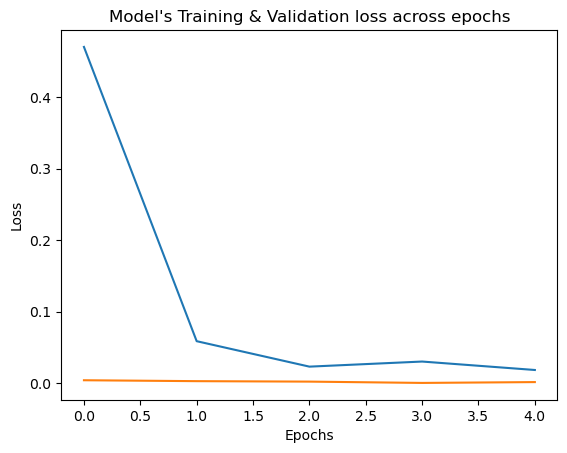

In [67]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')

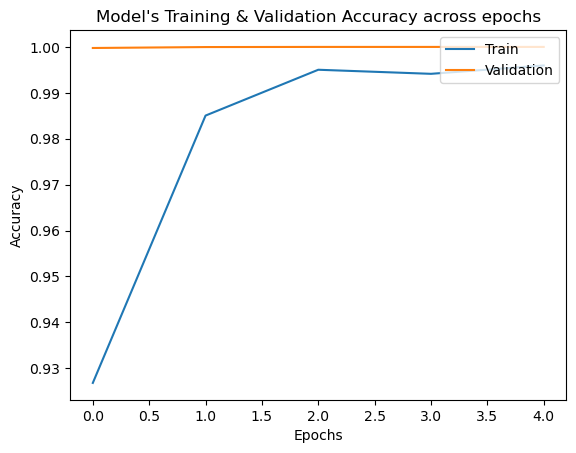

In [71]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title("Model's Training & Validation Accuracy across epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [119]:
# lets make some predicitons with the test set
prediction = model.predict(X_test)

9681/9681 [==============================] - 78s 8ms/step


In [120]:
binary_predictions = (prediction >= 0.5).astype(int)
# y_test = pd.DataFrame(y_test, columns=['Actual Outcome'])
prediction = pd.DataFrame(binary_predictions, columns=['Predicted Outcome'])
result_df = pd.concat([y_test, prediction], axis=1)
result_df

,Actual Outcome,Predicted Outcome
0,NaN,1
1,NaN,1
2,NaN,1
3,NaN,1
4,NaN,1
...,...,...
309765,NaN,1
309766,NaN,1
309767,NaN,1
309768,NaN,1


In [123]:
y_test.tail()

,Actual Outcome
